In [1]:
import requests
import datetime as dt
import pandas as pd
import numpy as np

# Extracting Data from Debank

In [2]:
url = 'https://api.debank.com/old/dex/histories' #user data
r = requests.get(url)
data = r.json()
data = data['data']
exchanges = {}

for i in range(len(data)):
    exchanges[i] = data[i]['dates']

### DEX List

In [3]:
dex_list = []
for i in range(len(exchanges)):
    dex_list.append (exchanges[i][0]['project_id'])

dex_list

['1inch',
 '1inch2',
 'airswap',
 'anyswap',
 'balancer',
 'bancor',
 'cofix',
 'curve',
 'defiswap',
 'dexag',
 'dforcetrade',
 'dodoex',
 'dydx',
 'equalizer',
 'ichi',
 'kyber',
 'matcha',
 'miniswap',
 'mooniswap',
 'mstable',
 'paraswap',
 'powerpool',
 'sakeswap',
 'sfinance',
 'shell',
 'snowswap',
 'sunflowerswap',
 'sushiswap',
 'swerve',
 'tokenlon',
 'totle',
 'uniswap',
 'uniswap2',
 'yflink',
 'yfv']

### User & Volume Data for All DEXes Available on Debank

<AxesSubplot:title={'center':'DEX Aggregate Daily Volume; USD'}>

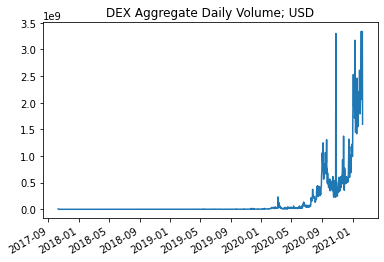

In [4]:
dex_user = {}
dex_volume = {}

for i in range(len(dex_list)): 

    user = []
    date = []
    volume = []
    for z in range (len(exchanges[i])):
        user.append (exchanges[i][z]['active_user_count'])
        date.append(dt.datetime.strptime (exchanges[i][z]['date_at'], '%Y-%m-%d'))
        volume.append(exchanges[i][z]['amount'])

    dex_user[i] = pd.DataFrame(data = user, index = date, columns = [dex_list[i]])
    dex_user[i] = dex_user[i].sort_index()
    
    dex_volume[i] = pd.DataFrame(data = volume, index = date, columns = [dex_list[i]])
    dex_volume[i] = dex_volume[i].sort_index()
    

## Merging DataFrames

frames_user = []
frames_volume = []
for i in range(len(dex_list)):
    frames_user.append(dex_user[i])
    frames_volume.append(dex_volume[i])
    
## DEX Volume Aggregation
dex_volumes = pd.concat (frames_volume, axis=1, sort=False)
aggregate_dex = dex_volumes.sum(axis=1)
aggregate_dex.plot(title='DEX Aggregate Daily Volume; USD')

<AxesSubplot:>

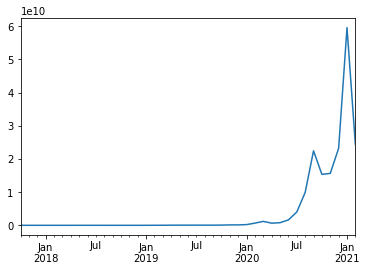

In [5]:
# MONTHLY DATA
dex_monthly_volume = aggregate_dex.groupby(pd.Grouper(freq="M")).sum()
dex_monthly_volume.plot()

# DEX Relative Volume

<AxesSubplot:title={'center':'Relative Volume'}>

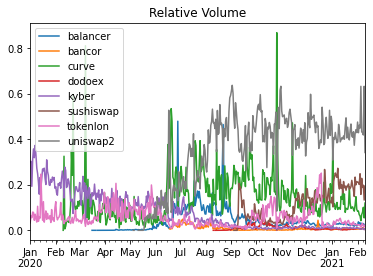

In [6]:
DEXes = ('balancer', 'bancor', 'curve', 'dodoex', 'kyber', 'sushiswap', 'tokenlon', 'uniswap2')

relative = {}
for i in range(len(DEXes)):
    relative[i] = ((dex_volumes[DEXes[i]] / aggregate_dex))
    
relative_volume = pd.concat([relative[i] for i in range(len(DEXes))], axis = 1)
relative_volume.columns = DEXes

relative_volume[relative_volume.index.year>=2020].plot(title = 'Relative Volume')

In [7]:
def save_pdf(figure, title):
    fig = figure.plot(title = title).get_figure()
    fig.savefig(title+'.pdf')

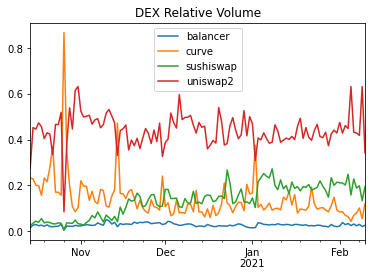

In [8]:
save_pdf(figure = relative_volume[relative_volume.index.year>=2020][-120:].drop(columns=['bancor', 'dodoex','tokenlon', 'kyber']), title = "DEX Relative Volume")

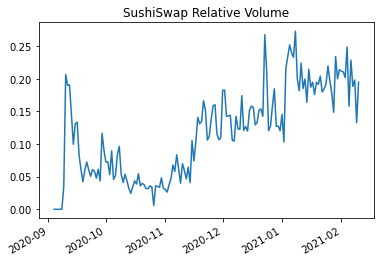

In [9]:
save_pdf(figure = relative_volume['sushiswap'], title = "SushiSwap Relative Volume")

# USER FRAME

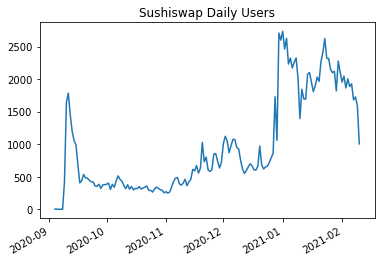

In [10]:
dex_users = pd.concat(frames_user, axis=1, sort=False)
aggregate_users = dex_users.sum(axis = 1)

relative_u = {}
for i in range(len(DEXes)):
    relative_u[i] = ((dex_users[DEXes[i]] / aggregate_users))
    
relative_users = pd.concat([relative_u[i] for i in range(len(DEXes))], axis = 1)
relative_users.columns = DEXes

save_pdf(dex_users['sushiswap'], "Sushiswap Daily Users")

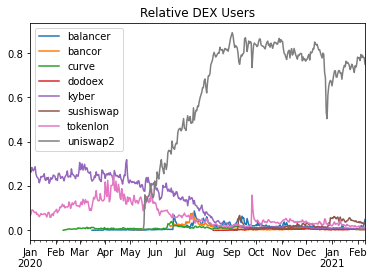

In [11]:
save_pdf(relative_users[relative_users.index.year>=2020], "Relative DEX Users")

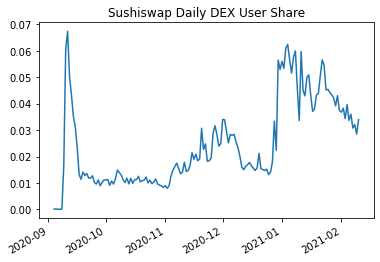

In [12]:
save_pdf(relative_users['sushiswap'], 'Sushiswap Daily DEX User Share')

## Volume Per User

balancer      42083.596024
bancor        15035.004374
curve        325590.093207
dodoex        46563.003173
kyber         13102.808947
sushiswap    119711.774421
tokenlon      13230.204405
uniswap2       9915.505698
dtype: float64


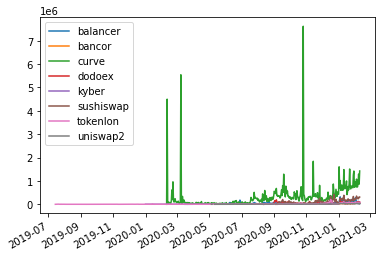

In [13]:
volume_per_user = dex_volumes[list(DEXes)] / dex_users[list(DEXes)]
volume_per_user.plot()

print(volume_per_user.mean())

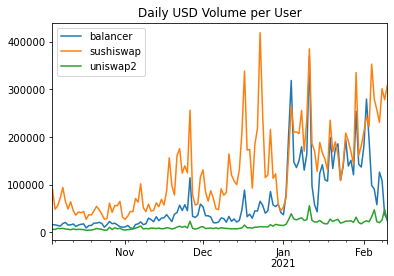

In [14]:
save_pdf (volume_per_user.drop(columns=['curve', 'bancor', 'dodoex','tokenlon', 'kyber'])[-130:], "Daily USD Volume per User")

In [15]:
np.average(volume_per_user['sushiswap'].dropna()), np.average(volume_per_user['uniswap2'].dropna())

(119711.77442122991, 9915.505698499774)

# TVL

In [16]:
url_part = 'https://api.debank.com/project/tvl_chart?id='
url = {}
for i in range(len(DEXes)):
    url[i] = url_part + DEXes[i]
    
r = {}
for i in range(len(url)):
    r[i] = requests.get(url[i])
    
data = {}
for i in range(len(url)):
    data[i] = r[i].json()['data']
    
date = {}
tvl = {}
for i in range(len(data)):
    date[i] = []
    tvl[i] = []
    for z in range (len(data[i])):
        date[i].append(dt.datetime.strptime (data[i][z]['date_at'], '%Y-%m-%d'))
        tvl[i].append(data[i][z]['locked_usd_value'])

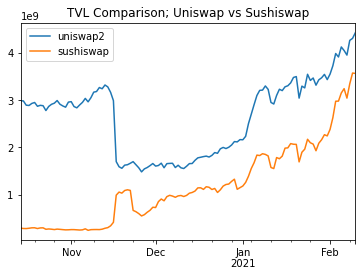

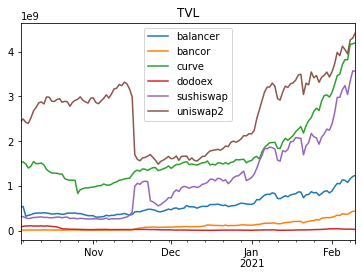

In [17]:
tvl_df = {}
for i in range(len(DEXes)):
    tvl_df[i] = pd.DataFrame(data = tvl[i], index = date[i], columns=[DEXes[i]])

frames_tvl = []
for i in range(len(tvl_df)):
    frames_tvl.append(tvl_df[i])
    
tvl_data = pd.concat (frames_tvl, axis=1, sort=False)

tvl_filtered = tvl_data[tvl_data.index.year>=2020]
volume_filtered = dex_volumes[list(DEXes)][dex_volumes.index.year>=2020]

save_pdf(tvl_filtered[['uniswap2', 'sushiswap']][-120:], "TVL Comparison; Uniswap vs Sushiswap")

save_pdf(tvl_filtered[-130:].drop(columns=['kyber', 'tokenlon']), 'TVL')

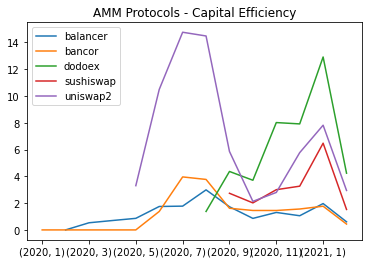

In [18]:
AMMs = ['balancer', 'bancor', 'dodoex', 'sushiswap', 'uniswap2']
monthly_volume_sum = (volume_filtered.groupby([lambda x: x.year, lambda x: x.month]).sum())[AMMs]
monthly_tvl_avg = (tvl_filtered.groupby([lambda x: x.year, lambda x: x.month]).mean())[AMMs]

save_pdf(monthly_volume_sum / monthly_tvl_avg, "AMM Protocols - Capital Efficiency")

# Price Data

In [19]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [20]:
def get_data_start_to_end(coin_name, start, end, currency = 'usd', data_type = "prices"):
    '''''''''
    get_data_start_to_end(coin_name = 'bitcoin', start = dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1))
    data_type could be market_caps or total volumes 
    '''''''''
    data = cg.get_coin_market_chart_range_by_id(id = coin_name, vs_currency = currency, from_timestamp = dt.datetime.timestamp(start), to_timestamp = dt.datetime.timestamp(end))
    data = data[data_type]
    date = []
    price = []
    for i in range(len(data)):
        date.append(dt.datetime.fromtimestamp((data[i][0])/1000))
        price.append(data[i][1])
    
    df = pd.DataFrame(data = price, index = date, columns=[coin_name])
    
    return df

<AxesSubplot:>

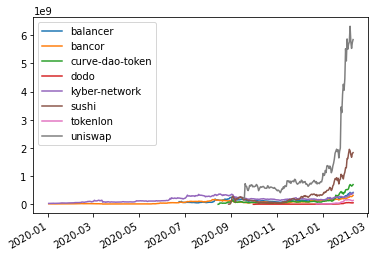

In [21]:
coin_list = ['balancer', 'bancor', 'curve-dao-token', 'dodo', 'kyber-network', 'sushi', 'tokenlon', 'uniswap']
total_supplies = [100000000, 98000000, 3303000000, 1000000000, 226000000, 250000000, 200000000, 1000000000]

df = {}
for i in range(len(coin_list)):
    df[i] = get_data_start_to_end(coin_list[i], start = dt.datetime(2020, 1, 1), end = dt.datetime.today())
    
price_data = pd.concat([df[i] for i in range(len(coin_list))], axis = 1)


df = {}
for i in range(len(coin_list)):
    df[i] = get_data_start_to_end(coin_list[i], start = dt.datetime(2020, 1, 1), end = dt.datetime.today(), data_type='market_caps')
    
market_cap = pd.concat([df[i] for i in range(len(coin_list))], axis = 1)


market_cap.plot()

## Volume to Market Cap Ratio (Monthly due to lack of data)

In [22]:
start = pd.to_datetime(dt.datetime.today().date())
volume_days = 30

market_cap.index = pd.to_datetime(market_cap.index.date)

def Volume_MC (volume_days, start, market_cap):
    
    #volume should be between start and end date with the lengths of 30 days
    
    volume_x_days = volume_filtered[(volume_filtered.index<=start) * (volume_filtered.index>=(start - dt.timedelta(volume_days)))]
    
    #volume to market cap ratio, where volume is the sum of previous 30 days while market cap is measured as of the last day of period
    
    VMC_ratio = np.array (volume_x_days.sum()) / np.array(market_cap[market_cap.index == start])
    VMC_ratio = pd.Series(list(VMC_ratio[:][0]), index = coin_list)
    
    return VMC_ratio

#check how ratio was moving during the time

starts = [start]
for i in range(3):
    starts.append(starts[i] - dt.timedelta(volume_days))
    
VMC = {}
for i in range(len(starts)):
    VMC[i] = Volume_MC (volume_days=30, start = starts[i], market_cap = market_cap)
    
for i in range(len(VMC)):
    print("____________________________________________________________________________")
    print("Period covered from", starts[i] - dt.timedelta(volume_days), "to", starts[i])
    print("____________________________________________________________________________")
    print(VMC[i])

____________________________________________________________________________
Period covered from 2021-01-11 00:00:00 to 2021-02-10 00:00:00
____________________________________________________________________________
balancer            4.006030
bancor              1.346666
curve-dao-token     9.222834
dodo                6.311484
kyber-network       1.403511
sushi               6.934503
tokenlon           13.363211
uniswap             4.943702
dtype: float64
____________________________________________________________________________
Period covered from 2020-12-12 00:00:00 to 2021-01-11 00:00:00
____________________________________________________________________________
balancer             4.854094
bancor               1.597305
curve-dao-token     34.298082
dodo                23.385129
kyber-network        1.715569
sushi               12.995700
tokenlon           156.480781
uniswap             12.520451
dtype: float64
________________________________________________________________

## Volume to Fully Dilluted Market Cap Ratio (Monthly due to lack of data)

In [23]:
price_data.index = pd.to_datetime(price_data.index.date)

fully_dilluted_mc = []
for i in range(len(starts)):
    fully_dilluted_mc.append(np.array(price_data[price_data.index == starts[i]]) * total_supplies)

In [24]:
def Volume_FDMC (volume_days, start, fully_dilluted_mc):
    
    #volume should be between start and end date with the lengths of 30 days
    
    volume_x_days = volume_filtered[(volume_filtered.index<=start) * (volume_filtered.index>=(start - dt.timedelta(volume_days)))]
    
    #volume to market cap ratio, where volume is the sum of previous 30 days while market cap is measured as of the last day of period
    
    VMC_ratio = np.array (volume_x_days.sum()) / fully_dilluted_mc
    VMC_ratio = pd.Series(list(VMC_ratio[:][0]), index = coin_list)
    
    return VMC_ratio

In [25]:
VMC = {}
for i in range(len(starts)):
    VMC[i] = Volume_FDMC (volume_days=30, start = starts[i], fully_dilluted_mc = fully_dilluted_mc[i])
    
for i in range(len(VMC)):
    print("____________________________________________________________________________")
    print("Period covered from", starts[i] - dt.timedelta(volume_days), "to", starts[i])
    print("____________________________________________________________________________")
    print(VMC[i])

____________________________________________________________________________
Period covered from 2021-01-11 00:00:00 to 2021-02-10 00:00:00
____________________________________________________________________________
balancer           0.432858
bancor             1.550333
curve-dao-token    0.613907
dodo               0.211974
kyber-network      1.264621
sushi              3.549531
tokenlon           1.334092
uniswap            1.481739
dtype: float64
____________________________________________________________________________
Period covered from 2020-12-12 00:00:00 to 2021-01-11 00:00:00
____________________________________________________________________________
balancer           0.526153
bancor             1.593159
curve-dao-token    1.913904
dodo               0.653796
kyber-network      1.530411
sushi              6.645021
tokenlon           6.153820
uniswap            2.711904
dtype: float64
____________________________________________________________________________
Period cove

In [26]:
print (volume_filtered [volume_filtered.index>=(dt.datetime.today() - dt.timedelta(30))].sum()['sushiswap'] / 2.15)

5582257017.6729555


## Market Cap TVL Ratio

<AxesSubplot:>

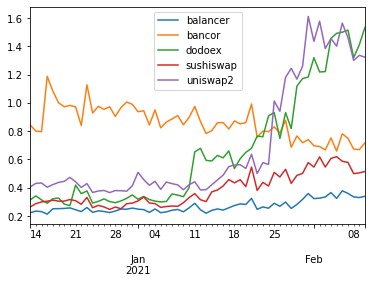

In [27]:
market_cap.columns = tvl_filtered.columns
mc_tvl = (market_cap[AMMs] / tvl_filtered[AMMs]).iloc[-60:] 
mc_tvl.plot()

## Fully Dilluted MC / TVL

In [28]:
token_supply = pd.Series(data = total_supplies, index = DEXes)
price_data.columns = tvl_filtered.columns
for i in range(len(price_data)-1):
    price_data.iloc[i:i+1] *= token_supply
fully_dilluted_data = price_data

<AxesSubplot:>

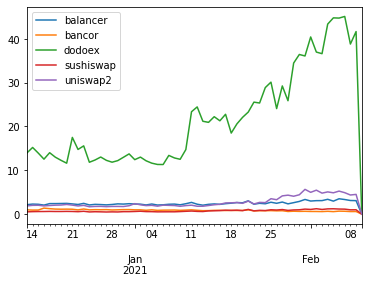

In [29]:
FD_tvl = (fully_dilluted_data[AMMs] / tvl_filtered[AMMs]).iloc[-60:]
FD_tvl.plot()